In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline
np.random.seed(0)

In [2]:
df = pd.read_csv('ab_browser_test.csv')
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
def get_bootstrap_samples(data, n_samples):
    for i in range(n_samples):
        indices = np.random.randint(0, len(data), len(data))
        samples = data[indices]
        yield samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [4]:
clicks_ctrl = df[df['slot'] == 'control']['n_clicks'].values
clicks_exp = df[df['slot'] == 'exp']['n_clicks'].values

## Clicks

In [5]:
print("Number of clicks for the control: ", clicks_ctrl.sum())
print("Number of clicks for the experiment: ", clicks_exp.sum())
print("Clicks difference in percents: ", (clicks_exp.sum() - clicks_ctrl.sum()) / clicks_ctrl.sum() * 100)

Number of clicks for the control:  3210027
Number of clicks for the experiment:  3261823
Clicks difference in percents:  1.61356898244


## Confident intervals using bootstrap

#### Median

In [6]:
clicks_median_ctrl = np.fromiter((np.median(sample) for sample in get_bootstrap_samples(clicks_ctrl, 1000)), float)
clicks_median_exp = np.fromiter((np.median(sample) for sample in get_bootstrap_samples(clicks_exp, 1000)), float)

print("95% confidence interval for the control clicks:",  stat_intervals(clicks_median_ctrl, 0.05))
print("95% confidence interval for the experiment clicks:",  stat_intervals(clicks_median_exp, 0.05))
print("95% confidence interval for the delta:",  stat_intervals(clicks_median_exp - clicks_median_ctrl, 0.05))

95% confidence interval for the control clicks: [ 4.  4.]
95% confidence interval for the experiment clicks: [ 5.  5.]
95% confidence interval for the delta: [ 1.  1.]


#### Mean

In [7]:
clicks_mean_ctrl = np.fromiter((np.mean(sample) for sample in get_bootstrap_samples(clicks_ctrl, 1000)), float)
clicks_mean_exp = np.fromiter((np.mean(sample) for sample in get_bootstrap_samples(clicks_exp, 1000)), float)

print("95% confidence interval for the control clicks:",  stat_intervals(clicks_mean_ctrl, 0.05))
print("95% confidence interval for the experiment clicks:",  stat_intervals(clicks_mean_exp, 0.05))
print("95% confidence interval for the delta:",  stat_intervals(clicks_mean_exp - clicks_mean_ctrl, 0.05))

95% confidence interval for the control clicks: [ 11.20679809  11.35869615]
95% confidence interval for the experiment clicks: [ 11.50965481  11.65920804]
95% confidence interval for the delta: [ 0.1980987   0.40880383]


## Student's t-test

In [8]:
n_boot_samples = 500

R ** 2:  0.998520754398


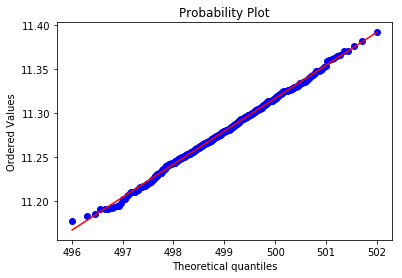

In [9]:
samples_mean = np.fromiter((np.mean(sample) for sample in get_bootstrap_samples(clicks_ctrl, n_boot_samples)), float)
(_, (_, _, r)) = stats.probplot(samples_mean, sparams=n_boot_samples - 1, plot=plt)
print("R ** 2: ", r ** 2)
plt.show()

R ** 2:  0.998381873066


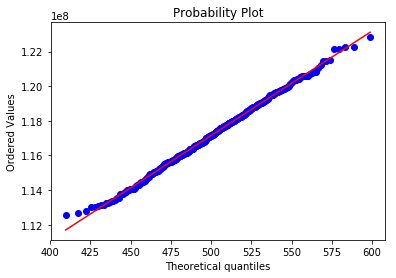

In [10]:
gen = ((np.sum((sample - np.mean(sample)) ** 2)) for sample in get_bootstrap_samples(clicks_ctrl, n_boot_samples))
control_boot_chi_squared = np.fromiter(gen, float)
(_, (_, _, r)) = stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n_boot_samples-1), plot=plt)
print("R ** 2: ", r ** 2)
plt.show()

## Mann–Whitney U test

In [11]:
clicks_grouped_ctrl = df[df['slot'] == 'control'].groupby('userID').aggregate(sum)['n_clicks'].values
clicks_grouped_exp = df[df['slot'] == 'exp'].groupby('userID').aggregate(sum)['n_clicks'].values
stats.mannwhitneyu(clicks_grouped_ctrl, clicks_grouped_exp)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

## Mann–Whitney U test for browsers

In [12]:
pvals = []
for browser in df['browser'].unique():
    clicks_browser_grouped_ctrl = df[(df['slot'] == 'control') & (df['browser'] == browser)]['n_clicks'].values
    clicks_browser_grouped_exp = df[(df['slot'] == 'exp') & (df['browser'] == browser)]['n_clicks'].values
    test = stats.mannwhitneyu(clicks_browser_grouped_ctrl, clicks_browser_grouped_exp)
    print("Mann–Whitney U test for", browser, test)
    pvals.append(test.pvalue)

Mann–Whitney U test for Browser #2 MannwhitneyuResult(statistic=1522572720.0, pvalue=0.027243860419724101)
Mann–Whitney U test for Browser #4 MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984)
Mann–Whitney U test for Browser #14 MannwhitneyuResult(statistic=806984730.5, pvalue=0.0)
Mann–Whitney U test for Browser #17 MannwhitneyuResult(statistic=131389681.0, pvalue=0.037400601430108017)
Mann–Whitney U test for Browser #20 MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377)
Mann–Whitney U test for Browser #22 MannwhitneyuResult(statistic=2547597959.5, pvalue=0.25740551522100319)


In [13]:
import statsmodels.stats.multitest as smm

smm.multipletests(pvals, method='holm')

(array([False, False,  True, False, False, False], dtype=bool),
 array([ 0.1362193 ,  0.81521235,  0.        ,  0.14960241,  0.81521235,
         0.77221655]),
 0.008512444610847103,
 0.008333333333333333)

## Nonclicks

In [14]:
for browser in df['browser'].unique():
    browser_grouped_ctrl = df[(df['slot'] == 'control') & (df['browser'] == browser)]
    browser_grouped_exp = df[(df['slot'] == 'exp') & (df['browser'] == browser)]
    print("Rate of non-clicks for control for: ", browser, browser_grouped_ctrl['n_nonclk_queries'].sum() / browser_grouped_ctrl['n_queries'].sum())
    print("Rate of non-clicks for experiment for: ", browser, browser_grouped_exp['n_nonclk_queries'].sum() / browser_grouped_exp['n_queries'].sum())
    print()

Rate of non-clicks for control for:  Browser #2 0.459627471792
Rate of non-clicks for experiment for:  Browser #2 0.449827469486

Rate of non-clicks for control for:  Browser #4 0.469709296351
Rate of non-clicks for experiment for:  Browser #4 0.451429419036

Rate of non-clicks for control for:  Browser #14 0.575904113601
Rate of non-clicks for experiment for:  Browser #14 0.437556173613

Rate of non-clicks for control for:  Browser #17 0.362993667463
Rate of non-clicks for experiment for:  Browser #17 0.369374128487

Rate of non-clicks for control for:  Browser #20 0.405404847434
Rate of non-clicks for experiment for:  Browser #20 0.389773764837

Rate of non-clicks for control for:  Browser #22 0.405939765935
Rate of non-clicks for experiment for:  Browser #22 0.398539472197

